### Training a Diffusion Model on Full Occupancy Data

This notebook is for training a diffusion model using the 2DUnet. This notebook is set up to use a very small dataset of voxel data collected from IsaacSim.

In [1]:
import torch
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("GPU Count:", torch.cuda.device_count())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


PyTorch Version: 2.5.1
CUDA Available: True
CUDA Version: 12.1
GPU Count: 1
GPU Name: NVIDIA GeForce RTX 4080


In [2]:
#########################################################
# Dataloader Code
#########################################################

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class VoxelGridDataset2DWithChannels(Dataset):
    def __init__(self, file_paths, grid_size=(16, 32, 32)):
        """
        Args:
            file_paths: List of file paths to numpy data files (.npy).
            grid_size: 3D grid size matching pointmap output (16x32x32).
        """
        self.file_paths = file_paths
        self.grid_size = grid_size

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load pointmap data
        file_path = self.file_paths[idx]
        voxel_grid = np.load(file_path)  # Shape: (16, 32, 32)

        # Ensure the data is in the expected shape
        assert voxel_grid.shape == self.grid_size, f"Expected shape {self.grid_size}, but got {voxel_grid.shape}"

        # Convert to torch tensor
        voxel_2d = torch.tensor(voxel_grid, dtype=torch.float32)

        return voxel_2d

# Get file paths for this hyper-specific set of point maps in the specialized data set
frame_numbers = [
    463, 867, 2371, 3078, 3564, 4527, 4865, 5031, 5923, 7788, 
    9024, 9673, 10306, 10898, 11250, 12462, 12601, 13012, 13716, 
    13942, 14353, 15300, 16941, 17246, 18216, 18615, 18842
]
file_paths = [
    f"training_data/small-dataset-pointmaps/vxl_pm_binary-{num}.npy"
    for num in frame_numbers
]

# Create dataset and dataloader
dataset_2d_channels = VoxelGridDataset2DWithChannels(file_paths)
dataloader = DataLoader(dataset_2d_channels, batch_size=4, shuffle=True, num_workers=4)

# Test the dataset output
for data in dataloader:
    print(data.shape)  # Should print torch.Size([4, 16, 32, 32])
    break

torch.Size([4, 16, 32, 32])


Original shape: torch.Size([16, 32, 32])


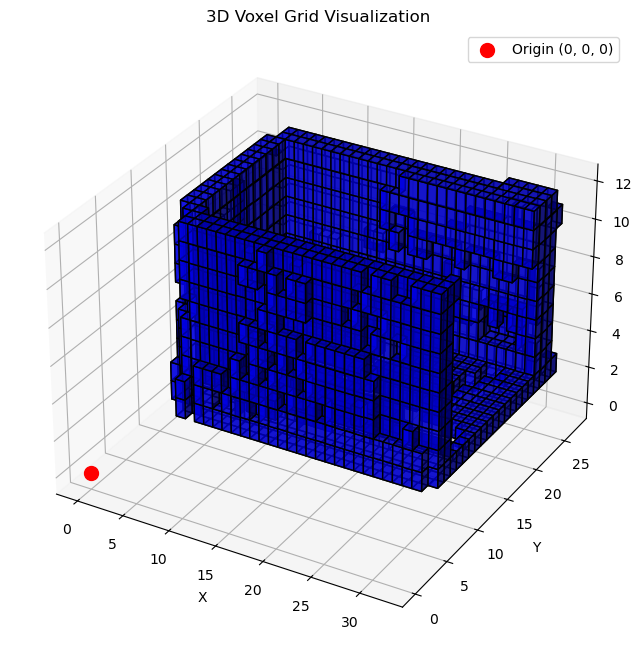

In [21]:
##########################################################
# Dataloader Visualization Code
##########################################################

import numpy as np
import matplotlib.pyplot as plt

def visualize_voxel_grid_scatter(voxel_grid, threshold=0.80):
    voxel_grid = np.asarray(voxel_grid.squeeze())
    assert voxel_grid.ndim == 3, "Voxel grid must be 3D."

    z, x, y = np.where(voxel_grid > threshold)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(x, y, z, c="blue", s=20, alpha=0.6)

    ax.scatter([0], [0], [0], color="red", s=80, label="Origin")
    ax.legend()

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("3D Voxel Grid Scatter (fast)")
    plt.show()

# Get a batch from the dataloader
batch = next(iter(dataloader))
voxel_grid = batch[0]
print("Original shape:", voxel_grid.shape)

# Visualize the voxel grid
visualize_voxel_grid(voxel_grid.numpy())

In [ ]:
#################################################
# Training Code
#################################################

import torch
import torch.nn as nn
import torch.optim as optim
from diffusers import DDPMScheduler
from diffusers import UNet2DModel

# Define constants
CURRENT_GRID_SIZE = (32, 32)
IN_CHANNELS = 16
OUT_CHANNELS = 16
EPOCHS = 1001
LEARNING_RATE = 1e-4
BATCH_SIZE = 16  # Adjust as per your memory capacity

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the 2D UNet model
model = UNet2DModel(
    sample_size=CURRENT_GRID_SIZE[0],  # Assuming square inputs
    in_channels=IN_CHANNELS,
    out_channels=OUT_CHANNELS,
    layers_per_block=2,
    down_block_types=("DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D"),
    block_out_channels=(128, 256, 512, 512),
).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()
scheduler = DDPMScheduler(num_train_timesteps=1000)

# Train the Model
for epoch in range(EPOCHS):
    total_loss = 0
    for step, xo in enumerate(dataloader):
        x0 = x0.to(device)

        # Random time step and noise
        batch_size = x0.size(0) # actual batch size can differ from what we requested when setting up the Dataloader so it's safer to match size this way
        t = torch.randint(0, scheduler.num_train_timesteps, (batch_size,), device=device).long()
        noise = torch.randn_like(x0)

        # Forward process
        noisy_x = scheduler.add_noise(x0, noise, t)

        # Model predicts the noise
        pred = model(noisy_x, t).sample

        # Compute loss
        loss = criterion(pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epoch % 10 == 0:
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch}, Avg Loss: {avg_loss:.4f}")


# TODO: Record the losses over the epochs so we can create a graph the loss

/home/lorin/anaconda3/envs/diffusers/lib/python3.11/site-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 0, Avg Loss: 1.0058
Epoch 10, Avg Loss: 0.2541
Epoch 20, Avg Loss: 0.1487
Epoch 30, Avg Loss: 0.1117
Epoch 40, Avg Loss: 0.1227
Epoch 50, Avg Loss: 0.1126
Epoch 60, Avg Loss: 0.0969
Epoch 70, Avg Loss: 0.0747
Epoch 80, Avg Loss: 0.0645
Epoch 90, Avg Loss: 0.0539
Epoch 100, Avg Loss: 0.0627
Epoch 110, Avg Loss: 0.0552
Epoch 120, Avg Loss: 0.0529
Epoch 130, Avg Loss: 0.0938
Epoch 140, Avg Loss: 0.0604
Epoch 150, Avg Loss: 0.0343
Epoch 160, Avg Loss: 0.0609
Epoch 170, Avg Loss: 0.0401
Epoch 180, Avg Loss: 0.0328
Epoch 190, Avg Loss: 0.0460
Epoch 200, Avg Loss: 0.0264
Epoch 210, Avg Loss: 0.0297
Epoch 220, Avg Loss: 0.0275
Epoch 230, Avg Loss: 0.0299
Epoch 240, Avg Loss: 0.0699
Epoch 250, Avg Loss: 0.0236
Epoch 260, Avg Loss: 0.0784
Epoch 270, Avg Loss: 0.0344
Epoch 280, Avg Loss: 0.0205
Epoch 290, Avg Loss: 0.0407
Epoch 300, Avg Loss: 0.0194
Epoch 310, Avg Loss: 0.0447
Epoch 320, Avg Loss: 0.0251
Epoch 330, Avg Loss: 0.0226
Epoch 340, Avg Loss: 0.0261
Epoch 350, Avg Loss: 0.0252
Epo

In [7]:
########################################
# Save The Model
########################################

import torch

save_path = "saved_models/unet2d_model.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), save_path)

print(f"Model saved to {save_path}")

Model saved to saved_models/unet2d_model.pth


In [8]:
########################################
# Reload the Model From Saved
########################################
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from diffusers import DDPMScheduler
from diffusers import UNet2DModel

# Define constants
CURRENT_GRID_SIZE = (32, 32)
IN_CHANNELS = 16
OUT_CHANNELS = 16
EPOCHS = 10001
LEARNING_RATE = 1e-4  # 1e-3 caused loss to oscillate between 0.9 and 1.1, 1e-5 the loss didn't reduce very much at all
BATCH_SIZE = 16  # Adjust as per your memory capacity

save_path = "saved_models/unet2d_model.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate the model with the same architecture
model = UNet2DModel(
            sample_size=32,
            in_channels=16,
            out_channels=16,
            layers_per_block=2,
            down_block_types=("DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
            up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D"),
            block_out_channels=(128, 256, 512, 512),
).to(device)

# Optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = DDPMScheduler(num_train_timesteps=1000)

# Load the saved weights
model.load_state_dict(torch.load(save_path))

# Set model to evaluation mode
model.eval()

print("Model successfully loaded!")

Model successfully loaded!


In [10]:
#################################################################
# Visualization Helper Methods
#################################################################

import numpy as np
import matplotlib.pyplot as plt

def set_axes_equal(ax):
    """
    Set equal aspect ratio for 3D axes.

    Args:
        ax (mpl_toolkits.mplot3d.axes3d.Axes3D): A matplotlib 3D axis.
    """
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max(x_range, y_range, z_range)

    x_middle = np.mean(x_limits)
    y_middle = np.mean(y_limits)
    z_middle = np.mean(z_limits)

    ax.set_xlim3d([x_middle - max_range / 2, x_middle + max_range / 2])
    ax.set_ylim3d([y_middle - max_range / 2, y_middle + max_range / 2])
    ax.set_zlim3d([-1, 32])

def visualize_voxel_grid(voxel_grid, threshold=0.5):
    """
    Visualize the 3D voxel grid using matplotlib's voxel plotting with equal axes.

    Args:
        voxel_grid (np.ndarray): A 3D numpy array representing the voxel grid (depth, height, width).
        threshold (float): Voxels with values above this threshold will be displayed.
    """
    # Ensure input is a 3D numpy array
    assert voxel_grid.ndim == 3, "The input voxel_grid must be a 3D array (depth, height, width)."

    # Transpose voxel grid from [channels, height, width] to [height, width, depth]
    voxel_grid = np.transpose(voxel_grid, (1, 2, 0))  # Convert to [x, y, z]

    # Get basic statistics about the voxel grid values
    # print(f"Voxel grid shape: {voxel_grid.shape}")
    # print(f"Min value: {voxel_grid.min():.4f}")
    # print(f"Max value: {voxel_grid.max():.4f}")
    # print(f"Mean value: {voxel_grid.mean():.4f}")
    # print(f"Median value: {np.median(voxel_grid):.4f}")
    # print(f"Standard deviation: {voxel_grid.std():.4f}")

    # Count values in different ranges
    print("\nValue distribution:")
    print(f"Values < 0: {np.sum(voxel_grid < 0)} ({np.mean(voxel_grid < 0):.1%})")
    print(f"Values 0-0.25: {np.sum((voxel_grid >= 0) & (voxel_grid < 0.25))} ({np.mean((voxel_grid >= 0) & (voxel_grid < 0.25)):.1%})")
    print(f"Values 0.25-0.5: {np.sum((voxel_grid >= 0.25) & (voxel_grid < 0.5))} ({np.mean((voxel_grid >= 0.25) & (voxel_grid < 0.5)):.1%})")
    print(f"Values 0.5-0.75: {np.sum((voxel_grid >= 0.5) & (voxel_grid < 0.75))} ({np.mean((voxel_grid >= 0.5) & (voxel_grid < 0.75)):.1%})")
    print(f"Values >= 0.75: {np.sum(voxel_grid >= 0.75)} ({np.mean(voxel_grid >= 0.75):.1%})")

    # Create a binary mask where voxel values exceed the threshold
    mask = voxel_grid >= threshold
    print(f"Number of visible voxels: {np.sum(mask)}")
    print(f"Voxel grid value range: [{voxel_grid.min()}, {voxel_grid.max()}]")

    # Create the plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")

    # Plot the voxel grid
    ax.voxels(mask, facecolors="blue", edgecolor="k", alpha=0.7)

    # Set equal aspect ratio
    set_axes_equal(ax)

    # Label the axes
    ax.set_xlabel("X-axis (Width)")
    ax.set_ylabel("Y-axis (Height)")
    ax.set_zlabel("Z-axis (Depth)")
    ax.set_title("3D Voxel Grid Visualization with Equal Axes")

    plt.show()

Inference for a single generation took 1.0972 seconds.

Value distribution:
Values < 0: 0 (0.0%)
Values 0-0.25: 14283 (87.2%)
Values 0.25-0.5: 0 (0.0%)
Values 0.5-0.75: 17 (0.1%)
Values >= 0.75: 2084 (12.7%)
Number of visible voxels: 2101
Voxel grid value range: [0.0, 1.0]


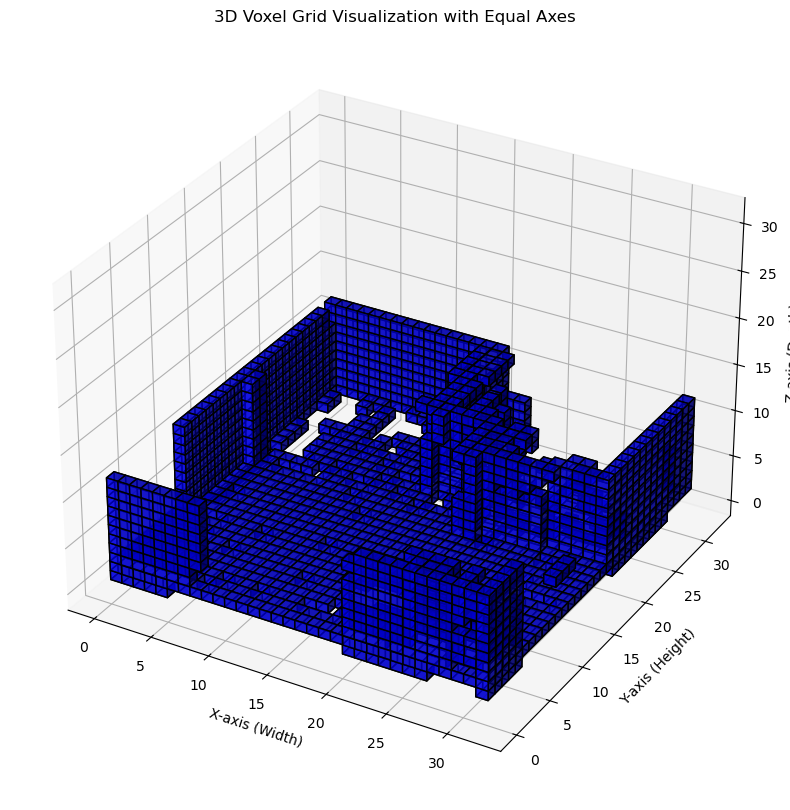

In [19]:
############################################
# Sample From the Model
############################################
import time

CURRENT_SHAPE = (1, 16, 32, 32)  # [batch_size, channels, height, width]
NUM_INFERENCE_STEPS = 150

scheduler.set_timesteps(num_inference_steps=NUM_INFERENCE_STEPS)

def sample_voxel_grid_2d(model, scheduler, shape=CURRENT_SHAPE):
    """
    Generate samples using the 2D UNet model.

    Args:
        model: Trained 2D UNet model.
        scheduler: Diffusion scheduler.
        shape: Shape of the input tensor (e.g., [1, 16, 32, 32]).

    Returns:
        voxel_grid: Generated 2D voxel grid as a numpy array.
    """
    model.eval()
    device = next(model.parameters()).device

    # Start from random noise
    x = torch.randn(shape).to(device)

    for t in reversed(range(scheduler.num_inference_steps)):
        with torch.no_grad():
            # Prepare timestep tensor
            t_tensor = torch.tensor([t], device=device).long()

            # Predict noise
            predicted_noise = model(x, t_tensor)["sample"]

            # Reverse diffusion step
            x = scheduler.step(model_output=predicted_noise, timestep=t, sample=x).prev_sample

    # Convert to numpy and normalize to [0, 1]
    voxel_grid = x.squeeze(0).cpu().numpy()  # Remove batch dimension
    voxel_grid = np.clip(voxel_grid, 0, 1)  # Clamp values to [0, 1]
    return voxel_grid

# Generate a voxel grid
start_time = time.perf_counter()
generated_voxel_grid = sample_voxel_grid_2d(model, scheduler, shape=CURRENT_SHAPE)
# print("Generated Voxel Grid Shape:", generated_voxel_grid.shape)
end_time = time.perf_counter()
elapsed_time = end_time - start_time

print(f"Inference for a single generation took {elapsed_time:.4f} seconds.")

visualize_voxel_grid(generated_voxel_grid, threshold=0.55)
